In [2]:
import sys
sys.path.append("../") # go to parent dir

import jax
import jax.numpy as jnp
import numpy as np
from matplotlib import pyplot as plt
import module.chebyshev_solver as chb

import optax
from tqdm import tqdm
key = jax.random.PRNGKey(5)

## Idea
We want to check that different initial conductivity guesses converge to the same minimum of the loss function. Therefore we spawn different k randomly and let them evolve for a long time.

In [3]:
n_k_init = 25

In [4]:
solver = chb.Solver(N = 10)
xx = solver.xx
yy = solver.yy
grid = solver.grid
dims = (solver.N, solver.N)
mask = np.ones(dims)
mask[1:-1,1:-1] = 0
maskx = np.ones(dims)
maskx[:,1:-1] = 0
masky = np.ones(dims)
masky[1:-1,:] = 0
mask = jnp.array(mask)
ii, jj = jnp.meshgrid(jnp.arange(solver.N), jnp.arange(solver.N))
a = 1.4
index_decay = jnp.exp(-(ii+jj)/a)

k_cheby_init = jax.random.normal(key, shape = dims) * index_decay
k_cheby_init = k_cheby_init.at[0,0].set(k_cheby_init[0,0] + jnp.sum(index_decay)*2)
k_cheby_init = k_cheby_init.flatten()
k_init = (solver.I @ k_cheby_init).reshape(dims)

N_measure = 10
measurements = []
for i in range(N_measure):
    key, _ = jax.random.split(key)

    dirichlet_cheby = jax.random.normal(key, shape = dims) * index_decay
    dirichlet = (solver.I @ dirichlet_cheby.flatten()).reshape(dims)
    dirichlet *= mask

    sol = solver.solve(k_cheby_init, dirichlet)

    measurements.append((dirichlet, sol))

In [43]:
res_params = []
for m in range(n_k_init):
    params = []
        
    @jax.jit
    def get_neumann(solution):
        jx = (solution["dx T"] * solution["k"]).reshape(dims)
        jy = (solution["dy T"] * solution["k"]).reshape(dims)

        neumann = jnp.concatenate((jx[:,0], jy[-1,:], jx[:,-1], jy[0,:]), axis = 0)
        return neumann

    @jax.jit
    def distance(solution, target_solution):
        neumann = get_neumann(solution)
        target_neumann = get_neumann(target_solution)

        return jnp.sqrt(jnp.sum((neumann - target_neumann)**2))

    @jax.jit
    def get_solution(k_param, dirichlet):
        k_cheby = k_param["coeff"] * index_decay
        k_cheby = k_cheby.flatten()
        solution = solver.solve(k_cheby, dirichlet)
        return solution


    @jax.jit
    def get_solution_internal(k_cheby_flat, dirichlet):
        solution = solver.solve(k_cheby_flat, dirichlet)
        return solution
    ## 3. Optimize parameters
    @jax.jit
    def loss(k_param):
        acc = 0
        for i in range(N_measure):
            acc += distance(get_solution(k_param, measurements[i][0]), measurements[i][1])
        return acc

    @jax.jit
    def loss_internal(k_cheby_flat):
        acc = 0
        for i in range(N_measure):
            acc += distance(get_solution_internal(k_cheby_flat, measurements[i][0]), measurements[i][1])
        return acc
    
    
    ## 2. Initialise variational parameters
    key, _ = jax.random.split(key)
    k_cheby = jax.random.normal(key, shape = dims) * index_decay
    k_cheby = k_cheby.at[0,0].set(k_cheby[0,0] + jnp.sum(index_decay))
    k_param = {"coeff":k_cheby}


    g = jax.value_and_grad(loss)
    h = jax.hessian(loss_internal)
    # define
    optimizer = optax.sgd(learning_rate=0.003)

    # initialise
    optimizer_state = optimizer.init(k_param)

    err = []
    for i in tqdm(range(10000)):
        val, grad = g(k_param)
        err.append(val)

        updates, optimizer_state = optimizer.update(grad, optimizer_state, k_param)

        k_param = optax.apply_updates(k_param, updates)

        if i % 10 == 0:
            params.append(k_param)

    res_params.append(params)

100%|██████████| 10000/10000 [08:09<00:00, 20.43it/s]


In [ ]:
array = jnp.array([[param["coeff"] for param in params] for params in res_params])
#####  jnp.save("../data/multirunners", array)

In [5]:
# array saved
array = jnp.load("../data/multirunners.npy")

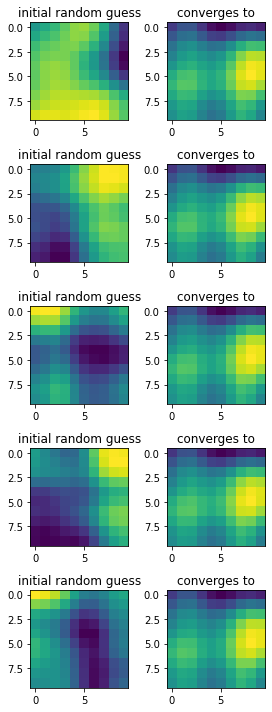

In [15]:
fig, axs = plt.subplots(5, 2, figsize = (4,10))

for i in range(5):
    axs[i,0].imshow((solver.I @ array[i,0].flatten()).reshape(dims))
    axs[i,0].set_title("initial random guess")
    axs[i,1].imshow((solver.I @ (array[i,-1] * index_decay).flatten()).reshape(dims))
    axs[i,1].set_title("converges to")


fig.tight_layout()

plt.savefig("../plot/runner_convergence.pdf")

---